## Imports


In [1]:
%%capture
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import itertools
from sklearn.utils import shuffle
%run "./utils.ipynb"
%run "./Data preprocessing.ipynb"

## Load Numpy Array

In [2]:
X.shape

(17615, 100, 100)

In [7]:
np.unique(y)

array([0, 1, 2, 3, 4])

### Resize array

In [8]:
X, y = shuffle(X, y, random_state=0)  

In [9]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


### Train

In [10]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [11]:
# Using early stopping and reduce lr on plateau to control the performance
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto', restore_best_weights=True)

cbs = [cb_1 , cb_2 ]

In [12]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 101, stratify=y)

In [13]:
model = Sequential()

conv_base = DenseNet201(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')
# conv_base.trainable = False
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

train_layers = [layer for layer in conv_base.layers[::-1][:2]]
# print(train_layers)
# print(len(train_layers), "train len")

for layer in conv_base.layers:
  if layer in train_layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 22,282,309
Trainable params: 22,045,317
Non-trainable params: 236,992
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1)

Train on 13211 samples, validate on 4404 samples
Epoch 1/8
13211/13211 [==============================] - 209s 16ms/sample - loss: 276.2558 - accuracy: 0.8080 - val_loss: 18.6209 - val_accuracy: 0.7636
Epoch 2/8
13211/13211 [==============================] - 149s 11ms/sample - loss: 5.2688 - accuracy: 0.8775 - val_loss: 2.2138 - val_accuracy: 0.8860
Epoch 3/8
13211/13211 [==============================] - 150s 11ms/sample - loss: 1.2208 - accuracy: 0.9478 - val_loss: 0.9933 - val_accuracy: 0.9457
Epoch 4/8
13211/13211 [==============================] - 151s 11ms/sample - loss: 0.9372 - accuracy: 0.9690 - val_loss: 0.9633 - val_accuracy: 0.9473
Epoch 5/8
13211/13211 [==============================] - 150s 11ms/sample - loss: 0.9004 - accuracy: 0.9746 - val_loss: 0.9751 - val_accuracy: 0.9607

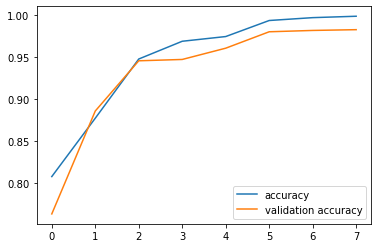

In [16]:
accuracy_graph(history)

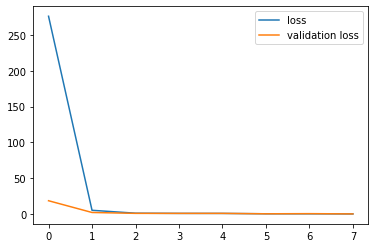

In [17]:
loss_graph(history)

In [18]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[897   1   1   2   3]
 [  0 825  50   0   0]
 [  0   9 866   0   0]
 [  6   0   0 868   1]
 [  3   0   0   0 872]]


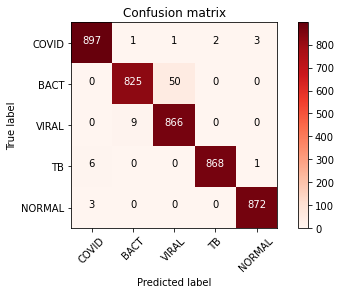

In [19]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [20]:
print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.99      0.94      0.96       875
           2       0.94      0.99      0.97       875
           3       1.00      0.99      0.99       875
           4       1.00      1.00      1.00       875

    accuracy                           0.98      4404
   macro avg       0.98      0.98      0.98      4404
weighted avg       0.98      0.98      0.98      4404

